## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from warnings import filterwarnings

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

The images are in simple folders. So, they first need to brought into a format which can be input into a neural network. To do this, I will add all the images to arrays and then preprocess them. Although the data is divided into training and testing sets, I will add it all to the same list, and then shuffle it well to increase accuracy.

## Importing images

In [3]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 67.88it/s]


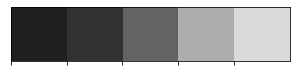

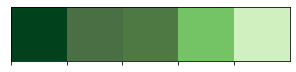

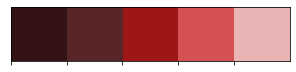

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

Visualising a few sample images is important for better understanding.

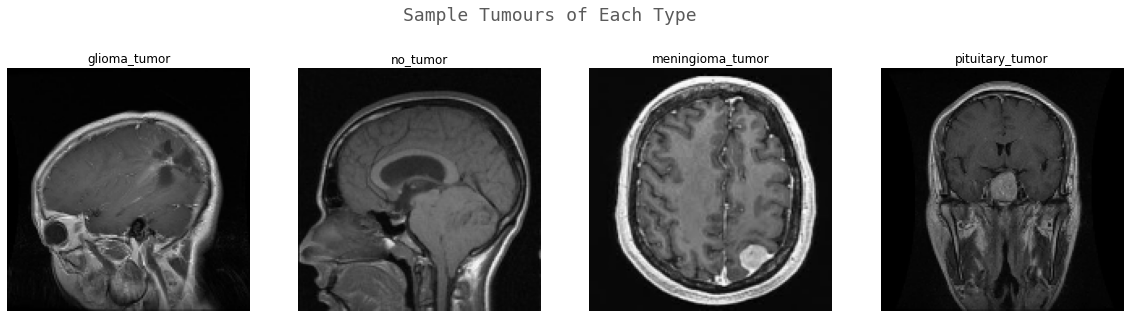

In [5]:
k = 0
fig, ax = plt.subplots(1,4,figsize = (20,20))
fig.text(s = 'Sample Tumours of Each Type',size = 18,fontname='monospace',color = colors_dark[1],y = 0.62,x = 0.4,alpha = 0.8)
for i in labels:
    j = 0
    while True :
        if y_train[j] == i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

In [6]:
X_train, y_train = shuffle(X_train, y_train, random_state = 101)

## Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 101)

This is a multiclass classification problem and therefore one hot encoding is appropriate.

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

I am going to use a pretrained model to reduce training effort and time.

So, all the CNNs layers, except the output layer will be from another popular pretrained model used for multiclass classification.

I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset. EfficientNetB0 is a convolutional neural network that is trained on more than a million images from the ImageNet database.

The include_top parameter is set to False so that the network doesn't include the output layer from the pre-built model. My model has its own customised output layer with one hot encoding.

## CNN

In [10]:
pretrained = EfficientNetB0(weights = 'imagenet',include_top = False,input_shape = (image_size, image_size, 3))

16711680/16705208 [==============================] - 1s 0us/step


In [11]:
model = pretrained.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate = 0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs = pretrained.input, outputs = model)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor = "val_accuracy",save_best_only = True, mode = "auto", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode = 'auto',verbose = 1)

## Model training

In [15]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 12, verbose = 1, batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
74/74 [==============================] - 24s 153ms/step - loss: 0.6764 - accuracy: 0.7359 - val_loss: 0.6981 - val_accuracy: 0.7863

Epoch 00001: val_accuracy improved from -inf to 0.78626, saving model to effnet.h5
Epoch 2/12
74/74 [==============================] - 8s 112ms/step - loss: 0.1792 - accuracy: 0.9367 - val_loss: 0.6355 - val_accuracy: 0.8244

Epoch 00002: val_accuracy improved from 0.78626 to 0.82443, saving model to effnet.h5
Epoch 3/12
74/74 [==============================] - 8s 112ms/step - loss: 0.1096 - accuracy: 0.9623 - val_loss: 0.3490 - val_accuracy: 0.8969

Epoch 00003: val_accuracy improved from 0.82443 to 0.89695, saving model to effnet.h5
Epoch 4/12
74/74 [==============================] - 8s 111ms/step - loss: 0.0879 - accuracy: 0.9693 - val_loss: 1.2965 - val_accuracy: 0.6794

Epoch 00004: val_accuracy did not improve from 0.89695
Epoch 5/12
74/74 [==============================] - 8s 112ms/step - loss: 0.0872 - accuracy: 0.9709 - val_loss: 0.371

## Evaluating model performance

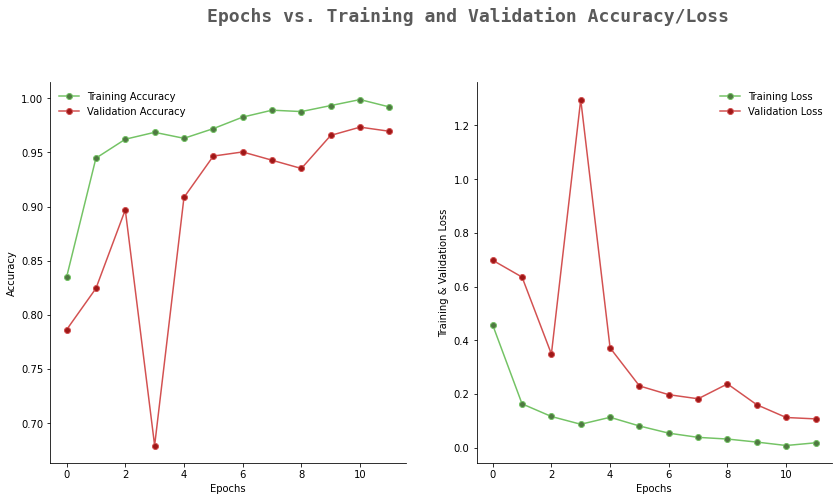

In [16]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
y_test_new = np.argmax(y_test,axis = 1)

## Evaluation metrics

In [18]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       168
           1       0.98      0.98      0.98       108
           2       0.97      0.98      0.97       201
           3       0.98      0.99      0.99       176

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



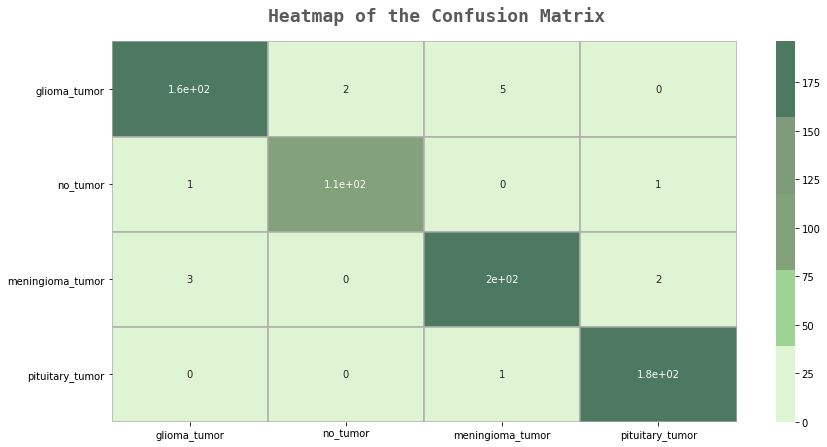

In [20]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()